Created on Friday 8 January 2021

**Group 5 - Clustering**  
**Clustering charts v1**

@authors : Theo Vedis, Jérémy Johann, Damien Izard, Nour Elhouda Kired, Paule Cadrelle Massag, Jessicka Mucy-Clavier, Gabriel nathir Kassem Rojas

This code compute the dataframe containg all the article content and id and clusterizes them into an optimal number of clusters.
This number is based on the maximum value of the error based on the silhouette corresponding to the optimal value of k clusters.
Then, the program train the model on k clusters and predict labels and a title to each label.
The title is given by the nearest points of each centroids based on a metric (cosine distance). We take the idf or bow of this articles and return the words which is as representative as possible of the cluster.

# Pip install

In [ ]:
!pip install scikit-learn-extra

     |████████████████████████████████| 624kB 9.0MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-learn-extra: filename=scikit_learn_extra-0.1.0b2-cp36-cp36m-linux_x86_64.whl size=339584 sha256=dd047bb1236dff4a35d6dd78eab4fbd9c1e9b5e98b9cad825a68a86685e6f073
  Stored in directory: /root/.cache/pip/wheels/04/01/0f/943bffb48bac048fa216b4325f1a6c939491ccb0ff500e08f4
Successfully built scikit-learn-extra


# Import libraries

In [ ]:
%matplotlib inline
import re
import os
import nltk
import pickle
import string
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from tqdm.notebook import tqdm
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from scipy.spatial import distance
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from nltk.stem import WordNetLemmatizer
from sklearn_extra.cluster import KMedoids
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import calinski_harabasz_score; silhouette_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Execute this block of code only if you wish to avoid warnings in the output
warnings.filterwarnings('ignore')

# Create link between drive and notebook

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importation of the data sets

In [ ]:
bow_g3: pd.DataFrame = pd.read_json("/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Input/g3_BOW_v1.json")

# Unwanted words that will be removed
whitelist: list = ["plus","tout","cette","ca","etre","dire","faut","fait","faire","donc","entreprise","gestion","entreprises","aussi","meme","bien","ete","comme","etat","ministre","tres","encore","peut","dont","egalement","notamment","ainsi","leurs","entre"]

# Functions

## First part:
We find the number optimal of cluster, we train and we predict.

In [ ]:
# Find the optimal number of clusters, k
def optimal_cluster(X: pd.DataFrame)->int:
  """Documentation
  Parameters:
      X: dataset containint all our datas we want to train the model with

  Out:
      (list_k[np.argmax(list_error_silhouette)]): optimal value of clusters, k
  """
  list_error_silhouette:list = []
  list_k:list = []
  K:range = range(9,26)
  sc: StandardScaler = StandardScaler()
  X: np.ndarray = sc.fit_transform(X)

  # create the range of k which are going to be used in our loop
  for k in tqdm(K):
    pca: PCA = PCA(n_components=10,random_state = 1)
    km = KMedoids(n_clusters=k,metric='cosine',  random_state=0)
    y = km.fit_predict(pca.fit_transform(X))
    # create a list with all k values
    list_k.append(k)
    # return the maximum of the error based on the silhouette corresponding to the optimal value of k
    list_error_silhouette.append(silhouette_score(X,y))
  
  plt.plot(K, list_error_silhouette)
  plt.title("Silhouette score for KMedoid clustering")
  plt.xlabel("n_cluster")
  plt.ylabel("Silhouette score")
  plt.show()

  return (list_k[np.argmax(list_error_silhouette)])

In [ ]:
# Train the chosen model on X matrix with the chosen number of clusters (nb_cluster) and return the trained model for later use
def training(X: pd.DataFrame, nb_cluster: int, path_save: str)->(KMedoids, PCA, StandardScaler):
  """Documentation
  Parameters:
      X: The data to predict
      nb_cluster : The number of cluster
      path_save : The path to save the model

  Out:
      km : The model
      pca : The pca
      sc : The normalisation
  """
  # Nomalisation
  sc: StandardScaler = StandardScaler()
  X: np.ndarray = sc.fit_transform(X)
  pickle.dump(sc, open(path_save + "scaler_cluster.pkl", 'wb'))

  # PCA
  pca: PCA = PCA(n_components=10,random_state = 1)
  X: np.ndarray = pca.fit_transform(X)
  pickle.dump(sc, open(path_save + "pca_cluster.pkl", 'wb'))

  # Kmenoids
  km: KMedoids = KMedoids(n_clusters=nb_cluster,metric='cosine',  random_state=0).fit(X)
  pickle.dump(sc, open(path_save + "model_cluster.pkl", 'wb'))
  
  return km, pca, sc

In [ ]:
# Prepares data for a 3D graph
def prepare_graph3D(bow) -> (pd.DataFrame, np.ndarray):
    """Documentation
    Parameters:
        bow: bow_g3 full dataframe

    Out:
        X: coordonnate for each article
        kmed_pred: KMedoids predictions
    """
    # Normalisation
    sc: StandardScaler = StandardScaler()
    X: np.ndarray = sc.fit_transform(bow.drop(["art_id", "art_content_clean_without_lem"], axis=1))

    # PCA
    pca: PCA = PCA(n_components=10,random_state = 1)
    X: np.ndarray = pca.fit_transform(X)

    # kmedoids
    kmed: KMedoids = KMedoids(n_clusters=9,metric='cosine',  random_state=0).fit(X)
    kmed_pred: np.ndarray = kmed.predict(X)

    return X, kmed_pred

In [ ]:
# Returns the labels of the documents
def predict(X: pd.DataFrame,model: KMedoids,pca: PCA,sc: StandardScaler)->list:
  """Documentation
  Parameters:
      X: The data to predict
      km: The model
      pca: The pca to make before to run the model
      sc: The normalisation to make before to run the pca

  Out:
      return prediction
  """
  # Normalisation
  X: np.ndarray = sc.transform(X)

  # PCA
  X: np.ndarray = pca.transform(X)

  # Predict
  return model.predict(X)

## Second Part :
We find the title of all the clusters

In [ ]:
# Calculate the chosen distance cosine between the values inside
# The cluster with label denomination and the centroid of this cluster.
def compute_distance(v: np.ndarray,km: KMedoids,label: int,pca: PCA,sc: StandardScaler)->list:
  """Documentation
  Parameters:
      v: The article to compute
      km: The model
      label: The number of the cluster
      pca: The pca to make before to run the model
      sc: The normalisation to make before to run the pca

  Out:
      distance bewteen the point and the center of the cluster
  """

  # We make the euclidian distance between the point and the center of the cluster
  return distance.cosine(pca.transform(sc.transform(v.reshape(1, -1))),km.cluster_centers_[label])

In [ ]:
def obtain_word(list_content: list, type = "idf")-> str:
  """Documentation
  Parameters:
      X: contains the data
      type : the type of word embedding so "idf" for TF-IDF and "bow" for BoW

  Out:
      (list_k[np.argmax(list_error_silhouette)]): optimal value of clusters, k
  """
  # We drop english word because there is some english word in the content
  if type == "idf":
    # Vectorizes all the tags in the train set while cleaning it from stop words
    vectorizer = TfidfVectorizer(stop_words = "english")
    X = vectorizer.fit_transform(list_content)
  # We drop english word because there is some english word in the content
  elif type == "bow":
    # Vectorizes all the tags in the train set while cleaning it from stop words
    vectorizer = CountVectorizer(stop_words = "english")
    X = vectorizer.fit_transform(list_content)
  # Return an error while the type specified is not idf or bow
  else:
    print("None")
    
  # We create a dataframe with the sum of the bow/td-idf and we take the 3 word with the biggest score
  temp_data = pd.DataFrame(np.array(np.sum(X,axis = 0))[0], columns = ["score"])
  temp_data["word"] = vectorizer.get_feature_names()

  # Create a word column from feature integer indices to feature name.
  temp_data = temp_data.sort_values(by = ["score"], ascending = False)

  return temp_data.iloc[0,1] + "/" + temp_data.iloc[1,1] + "/" + temp_data.iloc[2,1]

In [ ]:
# Get the contnt of an article except the words present in the whitelist
def whitelist_content(list_content: list, list_whitelist: list) -> np.ndarray:
  """Documentation
  Parameters:
      list_content: A list of articles
      list_whitelist: A whitelist of word

  Out:
      final_content: A list of articles without the word in the whitelist
  """
  # We create a list
  final_content: list = []

  for content in list_content:
    # We take every word witch are not present in whitelist
    temp_content = [w for w in content.split() if not w in list_whitelist]
    # We join all the word to create a sentence
    temp_content = " ".join(temp_content)
    final_content.append(temp_content)

  return np.array(final_content)

In [ ]:
# Allows you to obtain the labels for the articles
def get_label_title(data: pd.DataFrame,whitelist: list,km: KMedoids,pca: PCA,sc: StandardScaler) -> dict:
  """Documentation
  Parameters:
      data: A dataframe containing all our datas we want to work with
      whitelist: a whitelist of words we want to avoid in labels title

  Out:
      themes: A string containing our title of the chosen label
  """
  # We create the dictionnary that will contain the label corresponding to each cluster
  themes: dict = {}

  for label in np.unique(data["prediction"]):
    # We create a copy of the dataframe which only contain the cluster corresponding to the value of label
    sub_data = data.query("prediction == @label").drop(["prediction"],axis = 1).copy()

    # We compute the distance bewteen the center of the cluster and all the point of the cluster
    sub_data["score"] = sub_data.drop(["art_id","art_content_clean_without_lem"], axis = 1).apply(compute_distance,axis = 1,raw = True, args = (km,0,pca,sc))

    # We take the five closest document of the center
    head_content = sub_data.sort_values(by = ["score"], ascending = True).head(5)["art_content_clean_without_lem"].values

    # We drop the word in the whitelist
    head_content = whitelist_content(head_content,whitelist)

    # We get the label of ech cluster by checking the three recurents words
    themes[label] = obtain_word(head_content, type = "bow")

  return themes

## Third part :
We join the part one and the part two in one function

In [ ]:
# Clusters the dataset with the optimal number of clusters and return
def predict_cluster(data: pd.DataFrame, path_save: str)-> pd.DataFrame:
    """Documentation
    Parameters:
        data: A dataframe containing all our datas we want to work with
        path_save: example : "/content/drive/MyDrive/projetInterpromo2021/"

    Out:
        data[["art_id","prediction"]]: A dataframe containing our id and the title of the chosen label
        model: the model trained with the optimal number of clusters
    """
    # We use the function higher to obtain the good number of clusters
    nb_cluster = optimal_cluster(data.drop(["art_id","art_content_clean_without_lem"], axis = 1))
    print("We take " + str(nb_cluster) + " clusters.")

    # We train the kmenoide, pca and normalisation to make prediction
    model, pca, sc = training(data.drop(["art_id","art_content_clean_without_lem"], axis = 1),nb_cluster, path_save)

    # We predict the cluster with the kmenoide, pca and normalisation trained
    data["prediction"] = predict(data.drop(["art_id","art_content_clean_without_lem"], axis = 1),model, pca, sc)

    # We create a whitelist to drop some recurents word that was not drop
    whitelist = ["plus","tout","cette","ca","etre","dire","faut","fait","faire","donc"]

    # We create the label of each cluster
    data["name_theme"] = data["prediction"].map(get_label_title(data,whitelist,model,pca,sc))

    return data[["art_id","name_theme"]]

## Fourth part :
Execution of all the functions

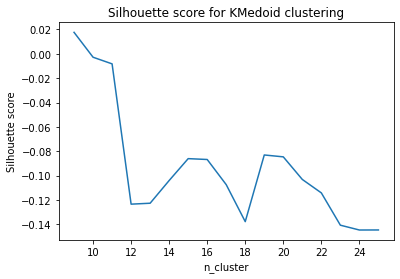

We take 9 clusters.


FileNotFoundError: ignored

In [ ]:
# We take out the model because we need to save it to predict later
bow_g3_result: pd.DataFrame = bow_g3.copy()
output: pd.DataFrame = predict_cluster(bow_g3_result, "/content/drive/MyDrive/projetInterpromo2021/")
output.head(5)

In [ ]:
print("Cluster_name / Population")
pd.Series(output["name_theme"]).value_counts()

# Optimal number of cluster

In [ ]:
# Calculating the optimal number of clusters
nb_cluster: int = optimal_cluster(bow_g3.drop(["art_id", "art_content_clean_without_lem"], axis=1))
print("We take " + str(nb_cluster) + " clusters.")

# Visualization

## Word cloud

In [ ]:
# Displays the wordcloud for each cluster
def wordcloud_bow(bow: pd.DataFrame, prediction: list, name: list=None):
    """Documentation
    Parameters:
        bow: Bag of Word
        prediction: the prediction that will be used to make distinction bewteen the differents class
        name: list of themes namess for each cluster
    """
    df: pd.DataFrame = bow.copy()
    df["pred"] = prediction

    for i in set(prediction):
        wordcloud: WordCloud = WordCloud(
            relative_scaling=1.0,
        ).generate_from_frequencies(
            dict(bow.loc[df[df["pred"] == i].index].sum(axis=0))
        )
        plt.imshow(wordcloud)
        plt.axis("off")
        if name is None:
            plt.title("Cluster " + str(i))
        else:
            plt.title(name[i])
        plt.show()

wordcloud_bow(bow_g3.drop(["art_id", "art_content_clean_without_lem", *whitelist], axis=1), bow_g3_result["prediction"], {i:j for i, j in zip(set(bow_g3_result["prediction"]), set(bow_g3_result["name_theme"]))})

## 3d representation

In [ ]:
# Displays data on the main components of the PCA
def graph_3d(data: pd.DataFrame, prediction: pd.Series, name: dict=None, axes: tuple=(0,1,2), opacity: dict=None):
    """Documentation
    Parameters:
        data: the data that will be show on the plot
        prediction: the prediction that will be used to make distinction bewteen the differents class on the plot
        name: clusters names (ex: {prediction_value: name})
        axes: axes of pca to display points
        opacity: the transparency of the points on the graph (ex: {prediction_value: opacity_value})
    
    Out:
        3D graph of data on the main components of the PCA
    """
    if opacity is None:
        opacity: dict = {val:1 for val in set(prediction)}
    if name is None:
        name: dict = {val:str(val) for val in set(prediction)}

    # Normalisation
    sc: StandardScaler = StandardScaler()
    X: np.ndarray = sc.fit_transform(data)

    # PCA
    pca: PCA = PCA(n_components=10)
    X: np.ndarray = pca.fit_transform(X)

    # Predict
    data_plot: pd.DataFrame = pd.DataFrame(X)
    data_plot["prediction"] = prediction

    # Create chart
    data: list = []
    for val in set(prediction):
        data_semi_plot: pd.DataFrame = data_plot[data_plot["prediction"] == val]
        data.append(go.Scatter3d(x=data_semi_plot[axes[0]], y=data_semi_plot[axes[1]], z=data_semi_plot[axes[2]], name=name[val], mode='markers',marker=dict(size=6), opacity=opacity[val]))

    fig: go.Figure = go.Figure(data)
    fig.show()

In [ ]:
# ACP + KMedoids
coord, pred = prepare_graph3D(bow_g3)
graph_3d(coord, pred)
pd.Series(pred).value_counts()